# SAMPLE RUNTHROUGH

## PREPARE DATA

In [8]:
with open('data/names.txt') as f:
    names = f.readlines()
names = [name.strip() for name in names]

itos = {}
stoi = {}

itos[0]='.'
stoi['.']=0

letters=sorted(list(set("".join(names))))

for idx,letter in enumerate(letters):
    stoi[letter]=idx+1
    itos[idx+1]=letter

print(stoi)
print(itos)



{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [20]:
# Don't change these parameters, as they are used in the explanation in the SAMPLE RUNTHROUGH part
SAMPLE_CONTEXT_SIZE = 3
SAMPLE_LETTER_EMBEDDING_SIZE=2
SAMPLE_TRAINING_DATA_SIZE=5
SAMPLE_HIDDEN_LAYER_NEURONS=100

In [13]:
import torch

def generate_training_data(names,block_size=3,print_out=False):
    X = []
    Y = []
    for name in names:
        name = name + "."
        context = block_size * [0]
        if print_out:
            print(name)
        for ch in name:
            context_str = "".join([itos[idx] for idx in context])
            predict_str = ch
            if print_out:
                print(f"{context_str}-->{predict_str}")
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:]+[stoi[ch]]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X, Y

X,Y = generate_training_data(names[:SAMPLE_TRAINING_DATA_SIZE],SAMPLE_CONTEXT_SIZE)



We have 32 examples with 3 context letters each

In [14]:
X.shape

torch.Size([32, 3])

## CREATE LETTER EMBEDDINGS

Represent each letter in alpabeth with 2 dimensional embedding vector. Initialize the embedding vectors randomly.

In [15]:
C = torch.randn(27,SAMPLE_LETTER_EMBEDDING_SIZE).float()
C.shape

torch.Size([27, 2])

Create embeddings "emb" for all the training samples for each context word.       
The result: A tensor (multidimensional matrix) with dimensions | Train size * Context Size * Letter embedding Size |

Where 

- Train size : How many training examples our data has 
- Context size : How many previous letters we use to predict the next letter
- Letter embedding size : How many dimensions we use to model 1 letter

In [16]:
emb = C[X] 
# C is 27 * 2
# X is 32 * 3 where each value is a letter index from 0-27 
# We basically choose a 2 dimensional vector for each letter index in X
emb.shape

torch.Size([32, 3, 2])

Below is the first training sample context letters as 2 dimensional vectors

In [9]:
emb[0]

tensor([[ 0.7815, -0.5151],
        [ 0.7815, -0.5151],
        [ 0.7815, -0.5151]])

## CREATE NEURON WEIGHTS

Each neuron has weight for all context letter all dimensions


In [21]:
W1 = torch.randn([SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE,SAMPLE_HIDDEN_LAYER_NEURONS])
W1.shape

torch.Size([6, 100])

Let's create bias parameter as well

In [22]:
b1 = torch.randn(SAMPLE_HIDDEN_LAYER_NEURONS) 
b1.shape

torch.Size([100])

## SHAPE TRAINING DATA SO WE COULD MATRIX MULTIPLY IT WITH NEURONS

This means the training data rows need to have have as many columns as neurons take inputs.

### NOT WELL PERFORMING SAMPLE 

The unbind operation seems to take a particular dimension and remove it in a way that instead of that dimension you will have that dimension represented in multiple lists for each dimension. It allows us to do easy concatenation.

In [ ]:
training_data = torch.cat(torch.unbind(emb,1),1) 

In [ ]:
training_data.shape

torch.Size([32, 6])

### BETTER PERFORMING SAMPLE 

View is a much faster operation compared to cat and bind because it does not need to use extra memory. It is also able to sort of unstack the tensor dimensions

In [ ]:
(torch.eq(training_data, emb.view(-1,6)).all())

tensor(True)

emb.view(-1,6)

## FIRST PART OF FORWARD PROPAGATION

Here we flow the data through first 100 neurons. 

For each sample we now get 100 values. 


In [19]:
training_data = emb.view(-1,SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE) 
h = training_data @ W1 + b1
h.shape

torch.Size([32, 100])

## COMPLETE ONE TIME FORWARD PASS

We create second layer with softmax function. There will be 27 neurons,
each neuron output will be a probability for particular letter

In [ ]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
logits = h.tanh() @ W2 + b2 
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)


Check that for each training sample the probabilities will equal = 1

In [ ]:
probs.sum(1,keepdim=True)

For each X get the probability for the right prediction. If it is low, the loglikelihood will return high loss

In [ ]:
loss  = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [ ]:
loss

## QUESTIONS


### QUESTION 1

- Are dimension mapping for each particular letter parameters in this neural network? 


### QUESTION 2

- If our dataset has 100 training examples. Each letter is mapped to 2 dimensions. We will have 100 neurons in middle layer and 27 neurons in the output layer. How many times for 1 ba

## ANSWERS 


### ANSWER 1

- Yes, these are All dimensions for the 27 letters . These we will update in each training run to reduce loss. These parameters affect the multiplication with each neuron in the first hidden layer. 



# MORE RESPECTABLE VERSION OF THIS 

Lets define some default hyperparameters

In [ ]:
EMBEDDING_DIMENSION = 2
CONTEXT_SIZE = 3
TRAINING_SIZE = -1
HIDDEN_LAYER_SIZE = 100

Let us now generate new training data

In [ ]:
X,Y = generate_training_data(names[:TRAINING_SIZE], block_size=CONTEXT_SIZE,print_out=False)

print(f"X shape {X.shape}")
print(f"Y shape {Y.shape}")

X shape torch.Size([228140, 3])
Y shape torch.Size([228140])


Initialize parameters

In [ ]:

def initialize_global_weights():
    global g, C, W1, B1, W2, B2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
    W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
    B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
    W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
    B2 = torch.randn(27) # Add to every neuron bias

    params = [C,W1,B1,W2,B2]
    param_count = sum([p.nelement()  for p in params])

    print(f"Total parameters currently in NN {param_count}")


    for p in params:
        p.requires_grad=True


initialize_global_weights()



Total parameters currently in NN 3481


## TRAINING WITH FULL DATA

In [ ]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation
    h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)


    print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1


    if i > 3:
        print("This is too slow, let's implement the minibatch approach")
        break






Total loss currently is 6.516178131103516
Total loss currently is 6.407242774963379
Total loss currently is 6.302850723266602
Total loss currently is 6.202707290649414
Total loss currently is 6.1065473556518555
This is too slow, let's implement the minibatch approach


## TRAINING WITH MINIBATCHES

In [ ]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])


    print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1





Total loss currently is 6.549178600311279
Total loss currently is 5.113999843597412
Total loss currently is 5.1251349449157715
Total loss currently is 6.682413578033447
Total loss currently is 4.9730634689331055
Total loss currently is 6.17246150970459
Total loss currently is 5.8346028327941895
Total loss currently is 6.0926079750061035
Total loss currently is 5.339205265045166
Total loss currently is 5.7882232666015625
Total loss currently is 5.949705123901367
Total loss currently is 4.603688716888428
Total loss currently is 5.587912082672119
Total loss currently is 4.940683841705322
Total loss currently is 4.808905124664307
Total loss currently is 5.440016269683838
Total loss currently is 5.021642208099365
Total loss currently is 4.437012195587158
Total loss currently is 5.02024507522583
Total loss currently is 5.108010292053223
Total loss currently is 4.983280181884766
Total loss currently is 5.9054765701293945
Total loss currently is 5.194680690765381
Total loss currently is 4.5935

## TRYING TO FIND THE BEST LEARNING RATE

In [ ]:
import torch.nn.functional as F


lre = torch.linspace(-3,0,1000)

lr = 10 ** lre

lri = []
lossi = []

for i in range(1000):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 100==0:
        print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * lr[i]

    lri.append(lre[i])
    lossi.append(loss.item())

    



Total loss currently is 4.846511363983154
Total loss currently is 4.302636623382568
Total loss currently is 4.043240547180176
Total loss currently is 3.549239158630371
Total loss currently is 2.557985544204712
Total loss currently is 2.4076554775238037
Total loss currently is 2.8072502613067627
Total loss currently is 2.3253140449523926
Total loss currently is 2.8695895671844482
Total loss currently is 2.904069185256958


We choose the learning rate from area where we see the loss is generally low.

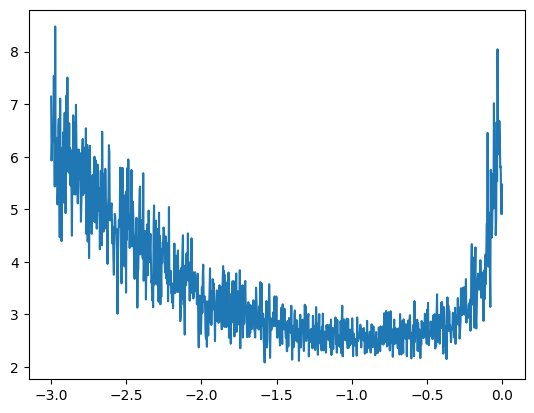

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lri,lossi)

## FURTHER TUNING TRAINING TO GET LOWEST LOSS POSSIBLE

In [ ]:
initialize_global_weights()

Total parameters currently in NN 3481


Total loss currently is 2.3229236602783203
Current learning rate is 0.10000000149011612
Total loss currently is 2.3811757564544678
Current learning rate is 0.09636363387107849
Total loss currently is 2.397203207015991
Current learning rate is 0.0918181836605072
Total loss currently is 2.362081289291382
Current learning rate is 0.08727272599935532
Total loss currently is 2.365567445755005
Current learning rate is 0.08272727578878403
Total loss currently is 2.3761329650878906
Current learning rate is 0.07818181812763214
Total loss currently is 2.3650588989257812
Current learning rate is 0.07363636046648026
Total loss currently is 2.3585476875305176
Current learning rate is 0.06909091025590897
Total loss currently is 2.355902671813965
Current learning rate is 0.06454545259475708
Total loss currently is 2.351731061935425
Current learning rate is 0.05999999865889549
Total loss currently is 2.3592441082000732
Current learning rate is 0.055454544723033905
Total loss currently is 2.33259081840

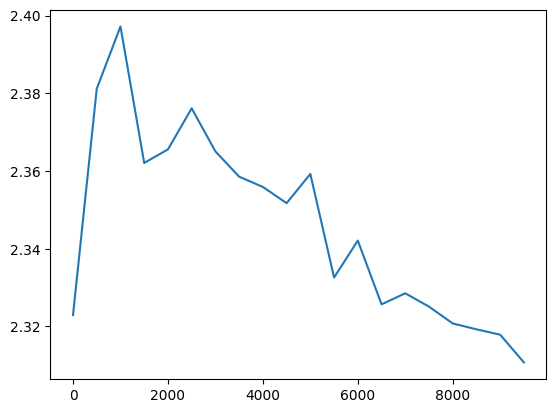

In [ ]:
import torch.nn.functional as F


MAX_ITER = 10000


lossi = []
iter = []


learning_rates = torch.linspace(0.1,0.01,100)


for i in range(MAX_ITER):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(32,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    learning_rate_idx = min(int(i / 10000 * 99), 99)
    learning_rate = learning_rates[learning_rate_idx]

    if i % 500==0:
        # Calculate total loss
        total_h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
        total_logits = total_h @ W2 + B2
        total_loss = F.cross_entropy(total_logits, Y)


        print(f"Total loss currently is {total_loss}")
        print(f"Current learning rate is {learning_rate}")
        
        iter.append(i)
        lossi.append(total_loss.item())

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * learning_rate 



plt.plot(iter,lossi)

## MANUAL FINE TUNING WITH SMALL LEARNING RATE

Total loss currently is 2.3016324043273926
Current learning rate is 0.005
Total loss currently is 2.300856351852417
Current learning rate is 0.005
Total loss currently is 2.3004424571990967
Current learning rate is 0.005
Total loss currently is 2.2992706298828125
Current learning rate is 0.005
Total loss currently is 2.30037522315979
Current learning rate is 0.005
Total loss currently is 2.2985219955444336
Current learning rate is 0.005
Total loss currently is 2.3004279136657715
Current learning rate is 0.005
Total loss currently is 2.299654483795166
Current learning rate is 0.005
Total loss currently is 2.299203395843506
Current learning rate is 0.005
Total loss currently is 2.2984459400177
Current learning rate is 0.005
Total loss currently is 2.2998554706573486
Current learning rate is 0.005
Total loss currently is 2.2993721961975098
Current learning rate is 0.005
Total loss currently is 2.299258232116699
Current learning rate is 0.005
Total loss currently is 2.300025701522827
Curre

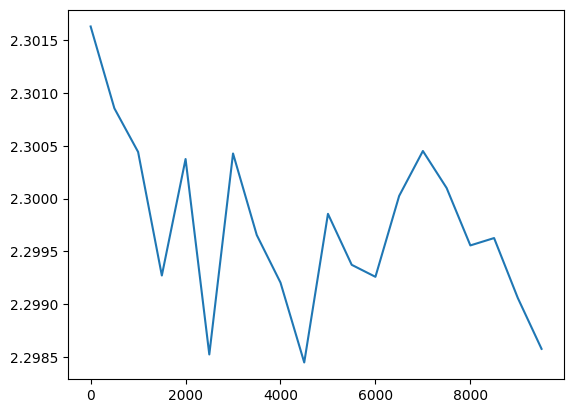

In [ ]:
import torch.nn.functional as F


MAX_ITER = 10000


lossi = []
iter = []


learning_rates = torch.linspace(0.1,0.01,100)


for i in range(MAX_ITER):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(32,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    learning_rate = 0.005
    
    if i % 500==0:
        # Calculate total loss
        total_h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
        total_logits = total_h @ W2 + B2
        total_loss = F.cross_entropy(total_logits, Y)

        print(f"Total loss currently is {total_loss}")
        print(f"Current learning rate is {learning_rate}")
        
        iter.append(i)
        lossi.append(total_loss.item())

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * learning_rate 



plt.plot(iter,lossi)

# MAKE TRAINING MORE REPEATABLE

In [ ]:
EMBEDDING_DIMENSION=4
CONTEXT_SIZE=3
HIDDEN_LAYER_SIZE=300

In [ ]:


def initialize_global_weights():
    global g, C, W1, B1, W2, B2, params
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
    W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
    B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
    W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
    B2 = torch.randn(27) # Add to every neuron bias

    params = [C,W1,B1,W2,B2]
    param_count = sum([p.nelement()  for p in params])

    print(f"Total parameters currently in NN {param_count}")


    for p in params:
        p.requires_grad=True

# Make all parameters to have gradient 


def train(X,Y, iterations, learning_rate, batch_size):
    for i in range(iterations):
        minibatch = torch.randint(0,X.shape[0],(batch_size,))
        h = (C[X[minibatch]].view(-1, CONTEXT_SIZE * EMBEDDING_DIMENSION) @ W1 + B1).tanh()
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y)

        print(f"Total loss currently is {loss}")

        for param in params:
            param.grad=None

        loss.backward()

        for param in params: 
            param.data -= param.grad * 0.1



initialize_global_weights()






Total parameters currently in NN 12135


NameError: name 'Xt' is not defined

# TRAIN/DEV/TEST SET

In [ ]:
import random
random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr,Ytr = generate_training_data(names[:n1])
Xdv,Ydv = generate_training_data(names[n1:n2])
Xts,Yts = generate_training_data(names[n2:])


Total parameters currently in NN 8135
